In [15]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install qiskit-aer

Note: you may need to restart the kernel to use updated packages.


In [17]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer import Aer
from numpy import *
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import * 
from scipy.optimize import minimize

The distance between two unitary operators $U_1$ and $U_2$ for a system of $n$ qubits is defined as:

$$
\text{HS Distance} = \sqrt{1 - \left(\frac{1}{2^{2n}}\right) \left|\text{Tr}(U_1^\dagger U_2)\right|^2}
$$

where:
- $U_1^\dagger$ is the adjoint (conjugate transpose) of $U_1$,
- $\text{Tr}(\cdot)$ denotes the trace of a matrix,
- $|\cdot|$ denotes the absolute value, and
- $n$ is the number of qubits in the system.


In [18]:
def calcualate_dist(U1, U2):
  n = 3 
  U1_dag = U1.adjoint().data
  U2 = U2.data
  tr = dot(U1_dag, U2).trace()
  # normalized
  distance = sqrt(1 - (1 / 2**(2*n)) * abs(tr)**2)
  return distance

The restriction is at most five 2-qubit gates, any number of 1-qubit gates, and no other gates. For gates A-B-C only we can only perform two-qubit operations on A-B and B-C. We can achieve this by using a CCZ gate. The Toffoli gate (CCX) gate is equivalent to a Controlled-Controlled Z (CCZ) gate surrounded by Hadamard (H) gates on the target qubit. 

I used this relation for the foundation of this CCX gate, but used controlled unitary gates with modifyable parameters to optimize my solution and achieve the minimim Hilbert Schmidt Distance. Since CU3 is depracated in Qiskit, we use a Controled Phase gate (cp) with the a unitary applied to the target qubit. 


In [19]:
def approx_toffoli_opt(qc, params):
    theta, phi, lambda_ = params

    # choose similar unitary placement as control Z
    # but optimize our rotation angle for min HS distance
    qc.h(2)
    qc.barrier()

    # CU3 is deprecated so use cp and u gates for control unitary
    qc.cp(lambda_, 1, 2)
    qc.u(theta, phi, lambda_, 2) 
    qc.cx(0, 1)
    qc.cp(-lambda_, 1, 2)
    qc.u(-theta, -phi, -lambda_, 2) 
    qc.cx(0, 1)
    qc.barrier()
    qc.t(0)
    qc.t(2)

    qc.barrier()
    qc.h(2)
    return qc

def optimize_approx_toffoli(params):
    # define actual toffoli unitary op 
    toffoli = QuantumCircuit(3)
    toffoli.ccx(0, 1, 2)
    toffoli_op = Operator(toffoli)

    # convert our circuit to unitary op
    qc = QuantumCircuit(3, 1)
    approx_toffoli_opt(qc, params)
    my_approx_op = Operator(qc)

    # minimize HS distance 
    n = calcualate_dist(my_approx_op, toffoli_op)
    return n

# start with the params for a t gate
initial_params = array([0, 0, pi/4])

result = minimize(optimize_approx_toffoli, initial_params, method='L-BFGS-B')

print("Optimal parameters:", result.x)
print("Minimum distance:", result.fun)

Optimal parameters: [-4.27083626e-07 -3.69443273e-08  1.57077890e+00]
Minimum distance: 0.3826834324499159


Testing these $\theta$, $\phi$, and $\lambda$ parameters in the circuit to see that it approximates the Toffoli, we see:

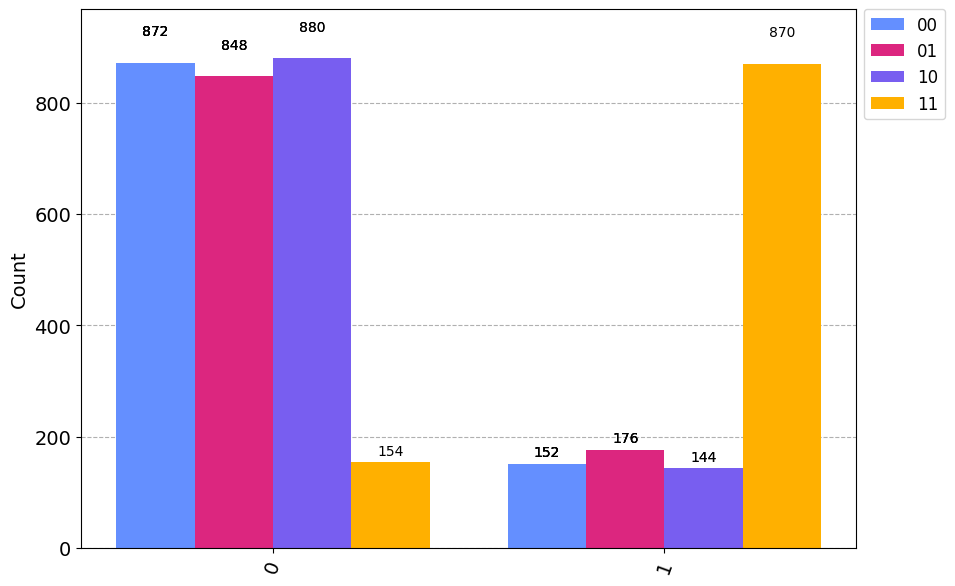

In [20]:
# test optimal circuit
opt_params = result.x

# |00> state
qc00 = QuantumCircuit(3, 1) 
# |01> state
qc01 = QuantumCircuit(3, 1) 
qc01.x(1)
# |10> state
qc10 = QuantumCircuit(3, 1) 
qc10.x(0)
# |11> state
qc11 = QuantumCircuit(3, 1) 
qc11.x(0)
qc11.x(1)

# apply toffoli gate to each of the initial states 
for circuit in [qc00, qc01, qc10, qc11]:
    approx_toffoli_opt(circuit, opt_params)
    circuit.measure(2, 0)

# record probabilities for each state
results = {}
for label, qc in zip(["00", "01", "10", "11"], [qc00, qc01, qc10, qc11]):
    simulator = Aer.get_backend('qasm_simulator')
    circ = transpile(qc, simulator)
    result = simulator.run(circ).result()
    counts = result.get_counts()
    results[label] = counts

# plot counts
counts_list = list(results.values())
legend = ['00', '01', '10', '11']
plot_histogram(counts_list, legend=legend, figsize=(10, 7))



The results of my approximate Toffoli show an output of |1> only when both controls are in the |11> state, giving the desired bitflip. There is some probability that a bitflip happens when the controls are not both in |11> as expected given that we are only apporximating the Toffoli. In this implementation I achieve a Hilbert-Schmidt distance of ≈ 0.38268 which seems to be as close as we can get to the real Toffoli given that we are restrained to only A-B and B-C connections of no more than 5 two qubit gates. 

In [22]:
# print the optimized circuit
qc00.draw()

░                                                               »
q_0: ──────░───────────────────────────────■───────────────────────────────»
           ░                             ┌─┴─┐                             »
q_1: ──────░──■──────────────────────────┤ X ├─────────────────■───────────»
     ┌───┐ ░  │P(1.5708) ┌───────────────┴───┴───────────────┐ │P(-1.5708) »
q_2: ┤ H ├─░──■──────────┤ U(-4.2708e-07,-3.6944e-08,1.5708) ├─■───────────»
     └───┘ ░             └───────────────────────────────────┘             »
c: 1/══════════════════════════════════════════════════════════════════════»
                                                                           »
«                                          ░ ┌───┐ ░         
«q_0: ─────────────────■───────────────────░─┤ T ├─░─────────
«                    ┌─┴─┐                 ░ └───┘ ░         
«q_1: ───────────────┤ X ├─────────────────░───────░─────────
«     ┌──────────────┴───┴───────────────┐ ░ ┌───┐ ░ ┌───┐┌─┐
«q_2: ┤ U(4.2708e-07,3.6944e-08,-1.5708) ├─░─┤ T ├─░─┤ H ├┤M├
«     └──────────────────────────────────┘ ░ └───┘ ░ └───┘└╥┘
«c: 1/═════════════════════════════════════════════════════╩═
«                                                          0